# Notebook to integrate our Plasma EV data with Hoshino

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import colors
import os
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler
from scipy import stats
from sklearn.decomposition import PCA
import ipywidgets
from numpy.random import rand
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn import cluster, datasets, mixture
from scipy.stats import norm
from scipy import misc
%matplotlib inline

In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal')

In [3]:
# load dfs

# this table is from  doi: 10.1016/j.cell.2020.07.009
dfRawHoshino = pd.read_excel('Hoshino_Cell2022_ProteinList_Human 512 Reports.xlsx', sheet_name='CleanedAndMetadataAdded')

# use this file from our Github support page: ProteinQuantitationWithSampleMetadata.xlsx
dfRawSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/Protein_pVals_Final_WithMetaData.xlsx', sheet_name='Sheet1')

### import, filter, and tidy raw protein quantitation

In [4]:
# tidy and filter Hoshino data

df = dfRawHoshino
df = df.replace([' '],np.nan) # change empty values to NaN
df = df.loc[:,~df.columns.str.contains('_remove')] # remove contaminants
df = df.query("species == 'human'")
df = df.query('sampleType == "plasma"')
df = df.query('category == "Area"')
df = df.query('cancer != "rm"')

df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df.drop(columns = ['sampleCode'], inplace = True) 	

numCols = df.columns[7:]
totalCols = df.columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column
dataset = 'hoshino' # for hoshino
df.insert(loc=1, column='dataset', value=dataset) 

dfHoshino = df
dfHoshino

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_89474/1275115324.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace([' '],np.nan) # change empty values to NaN


,cancerType,dataset,species,timing,category,cancer,sampleType,sample,protAcc,area
0,melanoma,hoshino,human,Pre,Area,c,plasma,MS14699QE_Bruno_Lyden_Mel01,A5A3E0,9.069801e+08
1,control,hoshino,human,Pre,Area,n,plasma,MS151649QE_Bruno_Lyden_control1_mom,A5A3E0,9.171840e+08
2,control,hoshino,human,Pre,Area,n,plasma,MS151649QE_Bruno_Lyden_control2_dad,A5A3E0,4.274898e+09
3,control,hoshino,human,Pre,Area,n,plasma,MS151970QE_Bruno_Lyden_control_dad_Jon,A5A3E0,1.531783e+09
4,control,hoshino,human,Pre,Area,n,plasma,MS151970QE_Bruno_Lyden_control_mom_HZ,A5A3E0,4.492545e+09
...,...,...,...,...,...,...,...,...,...,...
937423,control,hoshino,human,Pre,Area,n,plasma,MS151970QE_Bruno_Lyden_control_mom_HZ,O60237,4.428306e+07
1072966,liver,hoshino,human,Pre,Area,c,plasma,MS184612LUM_haiying_lyden_P01-020-ac2-B01_a,C9IZL6,1.571785e+08
1072969,lymphoma,hoshino,human,Pre,Area,c,plasma,MS184612LUM_haiying_lyden_P01-027-B01_a,C9IZL6,2.022394e+08
1306389,melanoma,hoshino,human,Pre,Area,c,plasma,MS14699QE_Bruno_Lyden_Mel01,H7C3J1,2.213091e+08


In [5]:
# tidy and filter sarcoma data

df = dfRawSarcoma

df = df.replace(0, np.nan) # change 0 to NaN
df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("timing == 'Pre' | timing=='Control'")
df = df.query("dataType == 'Intensity_Raw'")

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfSarcoma = df
dfSarcoma

,age,dataset,cancerType,gender,group,timing,dataType,patient,cancer,sample,sensitivity,race,protAcc,area
191,30-39,sarcoma,EPI,M,S.Pre,Pre,Intensity_Raw,BJW,c,BJW.S.Pre,S,WHITE,A0A075B6H7,380140.0
205,50-59,sarcoma,LS,M,R.Pre,Pre,Intensity_Raw,BPA,c,BPA.R.Pre,R,WHITE,A0A075B6H7,120820.0
207,60-69,sarcoma,LS,M,S.Pre,Pre,Intensity_Raw,BPE,c,BPE.S.Pre,S,WHITE,A0A075B6H7,106800.0
209,50-59,sarcoma,LS,F,S.Pre,Pre,Intensity_Raw,BPV,c,BPV.S.Pre,S,WHITE,A0A075B6H7,50621.0
215,70-79,sarcoma,PS/MFH,M,S.Pre,Pre,Intensity_Raw,BTK,c,BTK.S.Pre,S,WHITE,A0A075B6H7,56696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,30-39,sarcoma,control,M,Control,Control,Intensity_Raw,CTR,n,CTRL.Male.BR4,NaN,WHITE,Q9Y6Z7,12397550.0
263,60-69,sarcoma,control,M,Control,Control,Intensity_Raw,CTR,n,CTRL.Male.BR5,NaN,WHITE,Q9Y6Z7,11056870.0
265,60-69,sarcoma,LMS,F,S.Pre,Pre,Intensity_Raw,DBC,c,DBC.S.Pre,S,WHITE,Q9Y6Z7,2273860.0
267,30-39,sarcoma,MPNST,F,R.Pre,Pre,Intensity_Raw,DDK,c,DDK.R.Pre,R,WHITE,Q9Y6Z7,4065910.0


### annotate merged long/tidy data with uniprot IDs (or other metadata)

In [6]:
# make dfUniprot for annotation

# use uniprotAnnotationsForFigure2.xlxs from the Github page
dfUniprot = pd.read_excel('uniprot-download_true_fields_accession_2Creviewed_2Cid_2Cprotein_nam-2023.03.17-19.33.16.44.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# merge sarcoma and hoshino dfs on uniprot acession, then add in uniprot info

dfTemp = pd.concat([dfSarcoma, dfHoshino], axis=0, ignore_index = False, sort=False)

# annotate uniprot info by merging with dfUniprot
dfMerged = dfTemp.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfMerged.columns
numCols = dfMerged._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfMerged['area'] = dfMerged['area'].astype(float)

dfMerged.to_excel('dMerged.xlsx') # save
dfMerged

,age,dataset,cancerType,gender,group,timing,dataType,patient,cancer,sample,sensitivity,race,protAcc,area,species,category,sampleType,Reviewed,Protein names,geneNamePrimary
0,30-39,sarcoma,EPI,M,S.Pre,Pre,Intensity_Raw,BJW,c,BJW.S.Pre,S,WHITE,A0A075B6H7,3.801400e+05,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7
1,50-59,sarcoma,LS,M,R.Pre,Pre,Intensity_Raw,BPA,c,BPA.R.Pre,R,WHITE,A0A075B6H7,1.208200e+05,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7
2,60-69,sarcoma,LS,M,S.Pre,Pre,Intensity_Raw,BPE,c,BPE.S.Pre,S,WHITE,A0A075B6H7,1.068000e+05,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7
3,50-59,sarcoma,LS,F,S.Pre,Pre,Intensity_Raw,BPV,c,BPV.S.Pre,S,WHITE,A0A075B6H7,5.062100e+04,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7
4,70-79,sarcoma,PS/MFH,M,S.Pre,Pre,Intensity_Raw,BTK,c,BTK.S.Pre,S,WHITE,A0A075B6H7,5.669600e+04,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119616,NaN,hoshino,control,NaN,NaN,Pre,NaN,NaN,n,MS151970QE_Bruno_Lyden_control_mom_HZ,NaN,NaN,O60237,4.428306e+07,human,Area,plasma,reviewed,Protein phosphatase 1 regulatory subunit 12B (...,PPP1R12B
119617,NaN,hoshino,liver,NaN,NaN,Pre,NaN,NaN,c,MS184612LUM_haiying_lyden_P01-020-ac2-B01_a,NaN,NaN,C9IZL6,1.571785e+08,human,Area,plasma,unreviewed,"ST3 beta-galactoside alpha-2,3-sialyltransfera...",ST3GAL6
119618,NaN,hoshino,lymphoma,NaN,NaN,Pre,NaN,NaN,c,MS184612LUM_haiying_lyden_P01-027-B01_a,NaN,NaN,C9IZL6,2.022394e+08,human,Area,plasma,unreviewed,"ST3 beta-galactoside alpha-2,3-sialyltransfera...",ST3GAL6
119619,NaN,hoshino,melanoma,NaN,NaN,Pre,NaN,NaN,c,MS14699QE_Bruno_Lyden_Mel01,NaN,NaN,H7C3J1,2.213091e+08,human,Area,plasma,unreviewed,Testis specific serine kinase 4,TSSK4


In [8]:
# Filter: proteins by 15 detections across all samples
dfTemp = dfMerged

#drop 0 values
dfTemp['area'].replace(0, np.nan, inplace=True)
dfTemp.dropna(subset = ['area'], inplace = True)

dfTemp['nSamples'] = dfTemp.groupby('protAcc')['protAcc'].transform('count') # count

dfTemp = dfTemp.query('nSamples > 15') # filter by N detections

dfFiltered = dfTemp

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_89474/420571469.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfTemp['area'].replace(0, np.nan, inplace=True)


In [9]:
# Filter: rows without a single primary shared gene

dfTemp = dfFiltered

dfTemp.dropna(subset = ['geneNamePrimary'], inplace = True)

dfFiltered = dfTemp

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_89474/877096727.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTemp.dropna(subset = ['geneNamePrimary'], inplace = True)


In [10]:
# transform protein quantitation for each sample for consistency

dfTemp = dfFiltered

scaler = PowerTransformer(method='box-cox', standardize=True)

dfTemp['areaScaled']= dfTemp.groupby('sample')['area'].transform(lambda x: scaler.fit_transform(x.values[:,np.newaxis]).ravel())

dfNorm = dfTemp

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_89474/3853682016.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTemp['areaScaled']= dfTemp.groupby('sample')['area'].transform(lambda x: scaler.fit_transform(x.values[:,np.newaxis]).ravel())


In [11]:
dfTemp = dfNorm

dfTemp = pd.pivot_table(
    dfTemp,
    columns = 'sample',
    index = 'protAcc',
    values = "areaScaled",
    fill_value = 'NaN',
    )

dfTemp.index.rename('T: Protein IDs', inplace = True) # rename proteins to be consistent with what Harmonizer requires

# save
dfTemp.to_csv('/Users/jasonheld/Python/HarmonizR/_dfHarmonizer.tsv', sep="\t", index = True, na_rep='NaN')

* open dfMerged and the file above in the notebook VanTineEtAl_Harmonizer.ipynb on the github repo.
* this notebook is used to harmonize the sarcoma and Hoshino datasets using R v4.2.1.

### read back Harmonizer results

In [12]:
dfTemp = pd.read_table('/Users/jasonheld/Python/HarmonizR/result_file.tsv')
dfTemp = dfTemp.rename(columns={'Unnamed: 0' : 'protAcc'})

dfTemp = pd.melt(dfTemp,
    id_vars = 'protAcc',
    var_name = 'sample',
    value_name= 'areaHarmonized',
    )

dfTemp['areaHarmonizedAntilog'] = 2**dfTemp['areaHarmonized'] # antilog

# annotate uniprot info by merginf with dfUniprot
dfHarmonized = pd.merge(dfFiltered, dfTemp,
                     on =['sample', 'protAcc'], how ='left'
                     )

dfHarmonized.dropna(subset = ['areaHarmonized'], inplace=True)

### stats

In [13]:
# setup groups

dfTemp = dfHarmonized

cancerAll = dfTemp.query('cancer == "c"')
healthyAll = dfTemp.query('cancer == "n"')
cancerS = dfTemp.query('dataset == "sarcoma" & cancer == "c"')
healthyS = dfTemp.query('dataset == "sarcoma" & cancer == "n"')
cancerH = dfTemp.query('dataset == "hoshino" & cancer == "c"')
healthyH = dfTemp.query('dataset == "hoshino" & cancer == "n"')

In [14]:
#from statsmodels.stats.weightstats import ttest_ind
from statistics import mean
from scipy.stats import t

dfTemp = dfHarmonized
colName = 'geneNamePrimary'
valueCol = 'areaHarmonized'

allGenes = dfTemp['geneNamePrimary'].unique() # make a list of all genes

# to make new df
dfStats = pd.DataFrame()
geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = cancerAll.query("{0} == '{1}'".format(colName, i))
    group2 = healthyAll.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)
    group1List.append(group1['sample'])
    group2List.append(group2['sample'])
    
    if len(group1) < 2 or len(group2) < 2:
        
        if len(group1) < 2 and len(group1) < 2:
            oneGroupDetectionList.append('notdetected')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        
        elif len(group1) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')

        elif len(group2) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        continue
    else:
        oneGroupDetectionList.append('')
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False) # all outputs together
        pvalScipyList.append(p)

dfStats['geneNamePrimary'] = geneNamePrimaryList
dfStats['cancerAll'] = group1List
dfStats['healthyAll'] = group2List
dfStats['meanCancerAll']= group1MeanList
dfStats['meanHealthyAll']= group2MeanList
dfStats['oneGroupDetectionCancerAll'] = oneGroupDetectionList
dfStats['pvalScipyCancerAll'] = pvalScipyList

# define whether value goes up/down in group 1 versus group 2
dfStats['directionChangeCancerHealthyAll'] = np.where((dfStats['meanCancerAll'] > dfStats['meanHealthyAll']), 'up', 'down')
dfStats['directionChangeCancerHealthyAll'] = np.where(dfStats['oneGroupDetectionCancerAll'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChangeCancerHealthyAll'])
dfStats['directionChangeCancerHealthyAll'] = np.where(dfStats['oneGroupDetectionCancerAll'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChangeCancerHealthyAll'])
dfStats['directionChangeCancerHealthyAll'] = np.where(dfStats['oneGroupDetectionCancerAll'] == 'notDetected', 'notDetected', dfStats['directionChangeCancerHealthyAll'])

In [15]:
# Benjmani-hochburg correction
from statsmodels.stats.multitest import multipletests

scipyQvals = multipletests(dfStats.query("pvalScipyCancerAll != ''")['pvalScipyCancerAll'], alpha=0.05, method="fdr_bh")

dfStats.loc[dfStats['pvalScipyCancerAll'] != '', 'qvalScipyCancerAll'] = scipyQvals[1]

In [16]:
# annotate FDR significance

dfStats['sigFDRCancerAll'] = 'notSig' # set all to notSig first
dfStats.loc[pd.isnull(dfStats['qvalScipyCancerAll']), 'sigFDRCancerAll'] = 'sig'
dfStats.loc[dfStats['qvalScipyCancerAll'] < 0.05, 'sigFDRCancerAll'] = 'sig'
dfStats.loc[dfStats['directionChangeCancerHealthyAll']== 'notDetected', 'sigFDRCancerAll'] = 'notDetected'

# make list of significant genes
geneNamePrimarySigAll = dfStats.query('sigFDRCancerAll == "sig"')['geneNamePrimary'].tolist()

### Repeat stats for cancer vs. healthy in Sarcoma cohort only

In [17]:
dfTemp = dfStats
colName = 'geneNamePrimary'
valueCol = 'areaHarmonized'

allGenes = dfTemp['geneNamePrimary'].unique() # make a list of all genes

geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = cancerS.query("{0} == '{1}'".format(colName, i))
    group2 = healthyS.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)
    group1List.append(group1['sample'])
    group2List.append(group2['sample'])
    
    if len(group1) < 2 or len(group2) < 2:
        
        if len(group1) < 2 and len(group2) < 2 :
            oneGroupDetectionList.append('notDetected')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
            
        elif len(group1) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')

        elif len(group2) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')

        continue
    else:
        oneGroupDetectionList.append('')
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False) # all outputs together
        pvalScipyList.append(p)

dfStats['cancerS'] = group1List
dfStats['healthyS'] = group2List
dfStats['meanCancerS']= group1MeanList
dfStats['meanHealthyS']= group2MeanList
dfStats['oneGroupDetectionCancerS'] = oneGroupDetectionList
dfStats['pvalScipyCancerS'] = pvalScipyList

# define whether value goes up/down in group 1 versus group 2
dfStats['directionChangeCancerHealthyS'] = np.where((dfStats['meanCancerS'] > dfStats['meanHealthyS']), 'up', 'down')
dfStats['directionChangeCancerHealthyS'] = np.where(dfStats['oneGroupDetectionCancerS'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChangeCancerHealthyS'])
dfStats['directionChangeCancerHealthyS'] = np.where(dfStats['oneGroupDetectionCancerS'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChangeCancerHealthyS'])
dfStats['directionChangeCancerHealthyS'] = np.where(dfStats['oneGroupDetectionCancerS'] == 'notDetected', 'notDetected', dfStats['directionChangeCancerHealthyS'])

In [18]:
# Benjmani-hochburg correction
from statsmodels.stats.multitest import multipletests

scipyQvals = multipletests(dfStats.query("pvalScipyCancerS != ''")['pvalScipyCancerS'], alpha=0.05, method="fdr_bh")

dfStats.loc[dfStats['pvalScipyCancerS'] != '', 'qvalScipyCancerS'] = scipyQvals[1]

In [20]:
# select FDR significant

dfStats['sigFDRCancerS'] = 'notSig' # set all to notSig first
dfStats.loc[pd.isnull(dfStats['qvalScipyCancerS']), 'sigFDRCancerS'] = 'sig'
dfStats.loc[dfStats['qvalScipyCancerS'] < 0.05, 'sigFDRCancerS'] = 'sig'
dfStats.loc[dfStats['directionChangeCancerHealthyS']== 'notDetected', 'sigFDRCancerS'] = 'notDetected'

# make list of significant genes
geneNamePrimarySigS = dfStats.query('sigFDRCancerS == "sig"')['geneNamePrimary'].tolist()

### Repeat stats for cancer vs. healthy in Hoshino cohort only

In [21]:
dfTemp = dfStats
colName = 'geneNamePrimary'
valueCol = 'areaHarmonized'

allGenes = dfTemp['geneNamePrimary'].unique() # make a list of all genes

geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = cancerH.query("{0} == '{1}'".format(colName, i))
    group2 = healthyH.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)
    group1List.append(group1['sample'])
    group2List.append(group2['sample'])
    
    if len(group1) < 2 or len(group2) < 2:

        if len(group1) < 2 and len(group2) < 2 :
            oneGroupDetectionList.append('notDetected')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
            
        elif len(group1) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        elif len(group2) < 2:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
            
        continue
    else:
        oneGroupDetectionList.append('')
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False) # all outputs together
        pvalScipyList.append(p)

dfStats['cancerH'] = group1List
dfStats['healthyH'] = group2List
dfStats['meanCancerH']= group1MeanList
dfStats['meanHealthyH']= group2MeanList
dfStats['oneGroupDetectionCancerH'] = oneGroupDetectionList
dfStats['pvalScipyCancerH'] = pvalScipyList

# define whether value goes up/down in group 1 versus group 2
dfStats['directionChangeCancerHealthyH'] = np.where((dfStats['meanCancerH'] > dfStats['meanHealthyH']), 'up', 'down')
dfStats['directionChangeCancerHealthyH'] = np.where(dfStats['oneGroupDetectionCancerH'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChangeCancerHealthyH'])
dfStats['directionChangeCancerHealthyH'] = np.where(dfStats['oneGroupDetectionCancerH'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChangeCancerHealthyH'])
dfStats['directionChangeCancerHealthyH'] = np.where(dfStats['oneGroupDetectionCancerH'] == 'notDetected', 'notDetected', dfStats['directionChangeCancerHealthyH'])

In [22]:
# Benjmani-hochburg correction

scipyQvals = multipletests(dfStats.query("pvalScipyCancerH != ''")['pvalScipyCancerH'], alpha=0.05, method="fdr_bh")

dfStats.loc[dfStats['pvalScipyCancerH'] != '', 'qvalScipyCancerH'] = scipyQvals[1]

In [24]:
# select FDR significant

dfStats['sigFDRCancerH'] = 'notSig' # set all to notSig first
dfStats.loc[pd.isnull(dfStats['qvalScipyCancerH']), 'sigFDRCancerH'] = 'sig'
dfStats.loc[dfStats['qvalScipyCancerH'] < 0.05, 'sigFDRCancerH'] = 'sig'
dfStats.loc[dfStats['directionChangeCancerHealthyH']== 'notDetected', 'sigFDRCancerH'] = 'notDetected'

# make list of significant genes
geneNamePrimarySigH = dfStats.query('sigFDRCancerH == "sig"')['geneNamePrimary'].tolist()

### venn diagrams & plots

In [25]:
# summarize groupings
dfStats['cancerGrouping'] = 'sigInNeitherSNorHAlone'

dfStats['cancerGrouping'] = np.where(
    (dfStats['sigFDRCancerS'] == 'sig')
    &
    (dfStats['sigFDRCancerH'] == 'notSig'),
    'sigInS_notSigInH',
    dfStats['cancerGrouping'])

dfStats['cancerGrouping'] = np.where(
    (dfStats['sigFDRCancerS'] == 'sig')
    &
    (dfStats['sigFDRCancerH'] == 'notDetected'),
    'sigInS_notDetectedInH',
    dfStats['cancerGrouping'])

dfStats['cancerGrouping'] = np.where(
    (dfStats['sigFDRCancerH'] == 'sig')
    &
    (dfStats['sigFDRCancerS'] == 'notSig'),
    'sigInH_notSigInS',
    dfStats['cancerGrouping'])

dfStats['cancerGrouping'] = np.where(
    (dfStats['sigFDRCancerH'] == 'sig')
    &
    (dfStats['sigFDRCancerS'] == 'notDetected'),
    'sigInH_notDetectedInS',
    dfStats['cancerGrouping'])

dfStats['cancerGrouping'] = np.where(
    (dfStats['sigFDRCancerH'] == 'sig')
    &
    (dfStats['sigFDRCancerS'] == 'sig'),
    'sigInSandH',
    dfStats['cancerGrouping'])

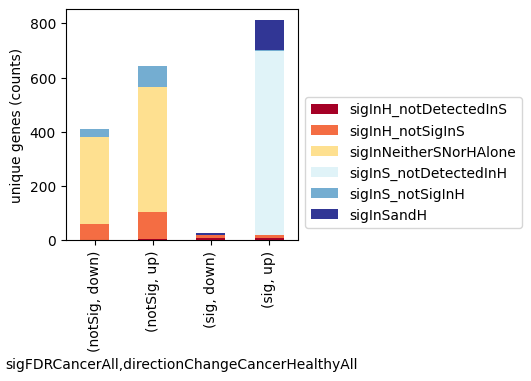

In [26]:
# plot with expression directional change, up and down
ax = pd.crosstab([dfStats['sigFDRCancerAll'],dfStats['directionChangeCancerHealthyAll']], dfStats['cancerGrouping']).plot(
    kind='bar',
    stacked=True,
    cmap='RdYlBu',
    figsize=(3,3)
)
ax.set_ylabel('unique genes (counts)')
ax.legend(bbox_to_anchor=(1, 0.15, 0.5, 0.5))
ax.figure.savefig('crossTabCancerUpAndDown.svg', bbox_inches='tight')
ax.figure.savefig('crossTabCancerUpAndDown.pdf', bbox_inches='tight')

In [27]:
# crosstab
ctab = pd.crosstab([dfStats['sigFDRCancerAll'],dfStats['directionChangeCancerHealthyAll']], dfStats['cancerGrouping'])
ctab

cancerGrouping                                   sigInH_notDetectedInS  \
sigFDRCancerAll directionChangeCancerHealthyAll                          
notSig          down                                                 2   
                up                                                   6   
sig             down                                                 7   
                up                                                   8   

cancerGrouping                                   sigInH_notSigInS  \
sigFDRCancerAll directionChangeCancerHealthyAll                     
notSig          down                                           57   
                up                                             98   
sig             down                                           14   
                up                                             10   

cancerGrouping                                   sigInNeitherSNorHAlone  \
sigFDRCancerAll directionChangeCancerHealthyAll                           
notSig          down                                                321   
                up                                                  462   
sig             down                                                  0   
                up                                                    2   

cancerGrouping                                   sigInS_notDetectedInH  \
sigFDRCancerAll directionChangeCancerHealthyAll                          
notSig          down                                                 0   
                up                                                   0   
sig             down                                                 0   
                up                                                 677   

cancerGrouping                                   sigInS_notSigInH  sigInSandH  
sigFDRCancerAll directionChangeCancerHealthyAll                                
notSig          down                                           31           1  
                up                                             75           3  
sig             down                                            0           5  
                up                                              3         111

## prevalence

In [28]:
# calculate prevalence

dfPrevalence = pd.DataFrame()

cancerSamples = dfHarmonized.query('cancer == "c"')

dfPrevalence['protAcc'] = cancerSamples.groupby(['protAcc', 'geneNamePrimary'])['protAcc'].unique()
dfPrevalence['geneNamePrimary'] = cancerSamples.groupby(['protAcc', 'geneNamePrimary'])['geneNamePrimary'].unique()

# count
dfPrevalence['nSamplesCancer'] = cancerSamples.groupby(['protAcc', 'geneNamePrimary'])['protAcc'].count().fillna(0)
dfPrevalence['prevalenceCancer'] = dfPrevalence['nSamplesCancer'] / cancerSamples['sample'].nunique()

normalSamples = dfHarmonized.query('cancer == "n"')
dfPrevalence['nSamplesNormal'] = normalSamples.groupby(['protAcc', 'geneNamePrimary'])['protAcc'].count().fillna(0)
dfPrevalence['prevalenceNormal'] = dfPrevalence['nSamplesNormal'] / normalSamples['sample'].nunique()

sarcomaSamples = dfHarmonized.query("cancerType in ['EPI', 'LS', 'PS/MFH', 'LMS', 'PMRMS', 'MPNST', 'MFS','AS', 'osteosarcoma', 'mpnst']")
dfPrevalence['nSamplesSarcoma'] = sarcomaSamples.groupby(['protAcc', 'geneNamePrimary'])['protAcc'].count().fillna(0)
dfPrevalence['prevalenceSarcoma'] = dfPrevalence['nSamplesSarcoma'] / sarcomaSamples['sample'].nunique()

sarcomaSamplesHoshino = sarcomaSamples.query('dataset == "hoshino"')
dfPrevalence['nSamplesSarcomaHoshino'] = sarcomaSamplesHoshino.groupby(['protAcc', 'geneNamePrimary'])['protAcc'].count().fillna(0)
dfPrevalence['prevalenceSarcomaHoshino'] = dfPrevalence['nSamplesSarcomaHoshino'] / sarcomaSamplesHoshino['sample'].nunique()

# some calcs
dfPrevalence['prevalenceSarcomaMinusNormal'] = dfPrevalence['prevalenceSarcoma'] - dfPrevalence['prevalenceNormal']
dfPrevalence['prevalenceCancerMinusNormal'] = dfPrevalence['prevalenceCancer'] - dfPrevalence['prevalenceNormal']
dfPrevalence['prevalenceSarcomaHoshinoMinusNormal'] = dfPrevalence['prevalenceSarcomaHoshino'] - dfPrevalence['prevalenceNormal']

[Text(0, 0.5, 'ACTB'),
 Text(0, 1.5, 'ANG'),
 Text(0, 2.5, 'CASP14'),
 Text(0, 3.5, 'CD9'),
 Text(0, 4.5, 'CFHR4'),
 Text(0, 5.5, 'CLDN5'),
 Text(0, 6.5, 'DSG1'),
 Text(0, 7.5, 'HSPA8'),
 Text(0, 8.5, 'MSN'),
 Text(0, 9.5, 'P4HB'),
 Text(0, 10.5, 'RALA'),
 Text(0, 11.5, 'RALB'),
 Text(0, 12.5, 'RAP1B'),
 Text(0, 13.5, 'RARRES2'),
 Text(0, 14.5, 'RHOC'),
 Text(0, 15.5, 'RNASE4'),
 Text(0, 16.5, 'THBS2'),
 Text(0, 17.5, 'TNC'),
 Text(0, 18.5, 'VCAN')]

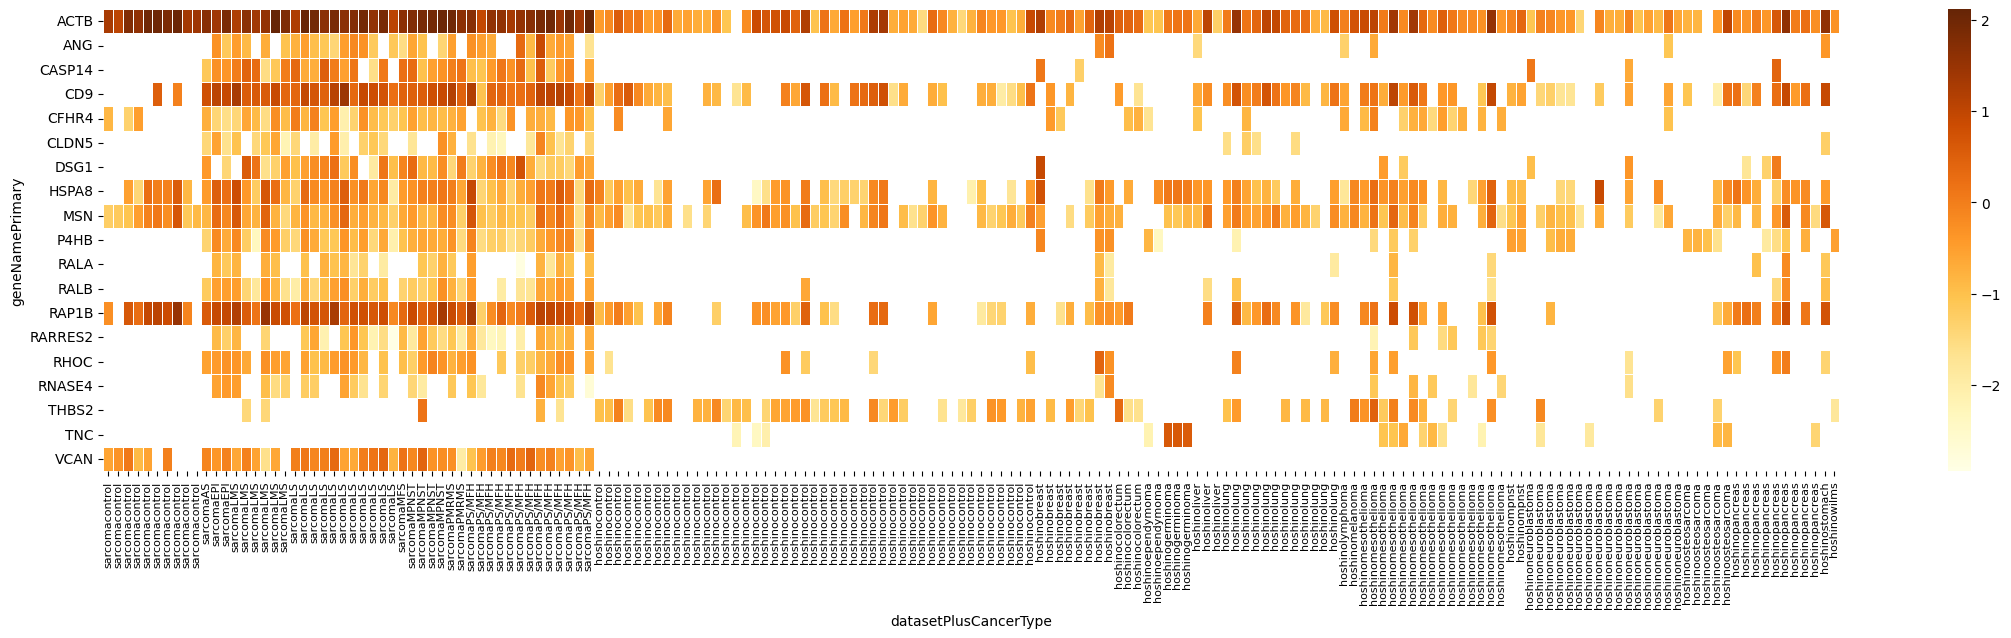

In [30]:
# heatmap

import colorcet as cc

df = dfHarmonized.copy(deep = True)
df['datasetPlusCancerType'] = df['dataset'] + df['cancerType']

# custom list
tgtList = ['P4HB','CASP14', 'DSG1', 'ANG', 'RALB', 'RARRES2', 'CLDN5', 'RHOC', 'RALA', 'RNASE4', 'CFHR4', #pan-cancer markers
           'VCAN', 'TNC', 'THBS2', # previously highlighted pan-cancer markers from Hoshino
           'HSPA8', 'CD9', 'ACTB', 'MSN', 'RAP1B', # EV markers
            ]
           
# for very specific sorting
cancerTypeCategories = ['sarcomacontrol', 'sarcomaAS', 'sarcomaEPI', 'sarcomaLMS', 'sarcomaLS', 'sarcomaMFS', 'sarcomaMPNST', 
                        'sarcomaPMRMS', 'sarcomaPS/MFH', 'hoshinocontrol', 'hoshinobreast', 'hoshinocolorectum', 
                        'hoshinoependymoma', 'hoshinogerminoma', 'hoshinoliver', 'hoshinolung', 'hoshinolymphoma', 'hoshinomelanoma', 
                        'hoshinomesothelioma', 'hoshinompnst', 'hoshinoneuroblastoma', 
                        'hoshinoosteosarcoma', 'hoshinopancreas', 'hoshinostomach', 'hoshinowilms']

df['cancerType4Sorting'] = pd.Categorical(df['datasetPlusCancerType'], categories = cancerTypeCategories, dtype="category")
df = df.sort_values(by = 'cancerType4Sorting')
                    
mask = df['geneNamePrimary'].isin(tgtList) # target genes
df = df.loc[mask] 

dfClusterMap = df.pivot_table(
            index = 'geneNamePrimary',
            columns = ['datasetPlusCancerType', 'sample'], # 'cancerType',
            values = 'areaHarmonized',
            )

cancerTypeLabels = list(dfClusterMap.columns.get_level_values('datasetPlusCancerType')) # list the cancertypes in order
dfClusterMap.columns = dfClusterMap.columns.droplevel(1) # then drop that level from the index

dfClusterMap = dfClusterMap.T # transpose

dfClusterMap['cancerType4Sorting'] = pd.Categorical(dfClusterMap.index, categories = cancerTypeCategories, dtype="category")
dfClusterMap = dfClusterMap.sort_values(by = 'cancerType4Sorting') # custom sort on the new column
dfClusterMap.drop(['cancerType4Sorting'], axis = 1, inplace = True) # drop that column
dfClusterMap = dfClusterMap.T # pivot back

maskNull = dfClusterMap.isnull()

# color metadata
palette = sns.color_palette(cc.glasbey, n_colors=len(df.cancerType.unique()))

lut = dict(zip(df.cancerType.unique(), palette))
df.index
col_colors = df.cancerType.map(lut)

plt.figure(figsize = (28,6))
ax = sns.heatmap(dfClusterMap, 
                 linewidths=.5, 
                 cmap = 'YlOrBr',
                 xticklabels = 1,
                 yticklabels = 1,
)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 8)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)

### MPNST marker in both datasets

[Text(0, 0.5, 'ACTB'), Text(0, 1.5, 'P4HB')]

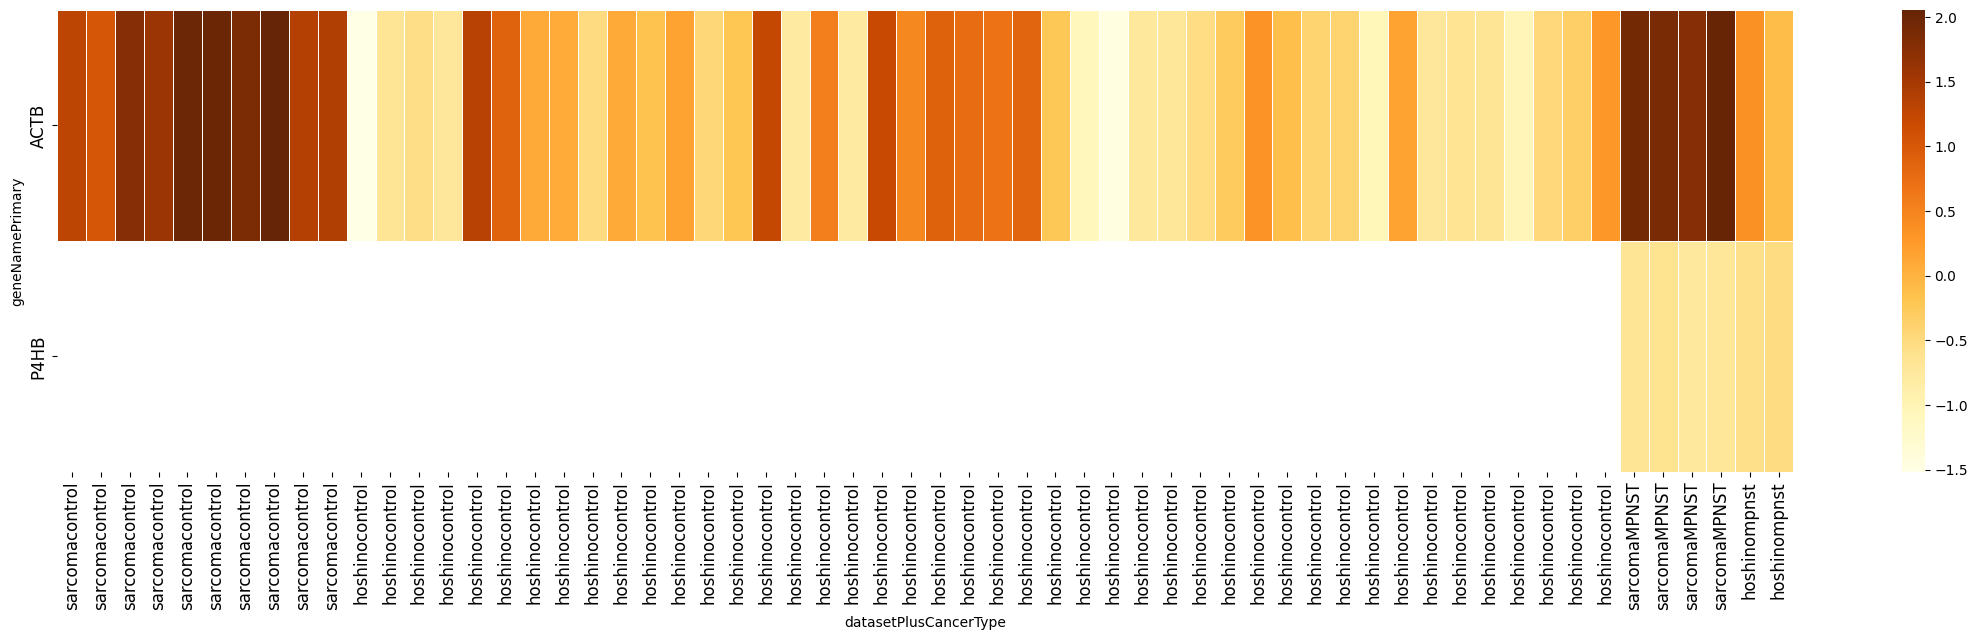

In [31]:
# heatmap
import colorcet as cc

df = dfHarmonized.copy(deep = True)

# filter for normal plus MPNST
df = df.query('cancerType == "MPNST" | cancerType == "mpnst" | cancer == "n"')
df['datasetPlusCancerType'] = df['dataset'] + df['cancerType']

tgtList = ['P4HB', 'ACTB']
           
# for very specific sorting
cancerTypeCategories = ['sarcomacontrol', 'hoshinocontrol', 'sarcomaMPNST', 'hoshinompnst']

df['cancerType4Sorting'] = pd.Categorical(df['datasetPlusCancerType'], categories = cancerTypeCategories, dtype="category")
df = df.sort_values(by = 'cancerType4Sorting')
                    
mask = df['geneNamePrimary'].isin(tgtList)  # target genes
df = df.loc[mask]

dfClusterMap = df.pivot_table(
            index = 'geneNamePrimary',
            columns = ['datasetPlusCancerType', 'sample'],
            values = 'areaHarmonized',
            )

cancerTypeLabels = list(dfClusterMap.columns.get_level_values('datasetPlusCancerType')) # list the cancertypes in order
dfClusterMap.columns = dfClusterMap.columns.droplevel(1) # then drop that level from the index

dfClusterMap = dfClusterMap.T # transpose

dfClusterMap['cancerType4Sorting'] = pd.Categorical(dfClusterMap.index, categories = cancerTypeCategories, dtype="category")
dfClusterMap = dfClusterMap.sort_values(by = 'cancerType4Sorting') # custom sort on the new column
dfClusterMap.drop(['cancerType4Sorting'], axis = 1, inplace = True) # drop that column
dfClusterMap = dfClusterMap.T # pivot back

maskNull = dfClusterMap.isnull()

# color metadata
palette = sns.color_palette(cc.glasbey, n_colors=len(df.cancerType.unique()))

lut = dict(zip(df.cancerType.unique(), palette)) # "paired" works
df.index
col_colors = df.cancerType.map(lut)

plt.figure(figsize = (28,6))
ax = sns.heatmap(dfClusterMap, 
                 linewidths=.5, 
                 cmap = 'YlOrBr',
                 xticklabels = 1,
                 yticklabels = 1,
)

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 12)

### Correlation plot / correlogram

[Text(1, 0.5, 'areaHarmonizedAntilog-pancreas'),
 Text(1, 1.5, 'areaHarmonizedAntilog-breast'),
 Text(1, 2.5, 'areaHarmonizedAntilog-germinoma'),
 Text(1, 3.5, 'areaHarmonizedAntilog-MPNST'),
 Text(1, 4.5, 'areaHarmonizedAntilog-neuroblastoma'),
 Text(1, 5.5, 'areaHarmonizedAntilog-osteosarcoma'),
 Text(1, 6.5, 'areaHarmonizedAntilog-colorectum'),
 Text(1, 7.5, 'areaHarmonizedAntilog-liver'),
 Text(1, 8.5, 'areaHarmonizedAntilog-LMS'),
 Text(1, 9.5, 'areaHarmonizedAntilog-PS/MFH'),
 Text(1, 10.5, 'areaHarmonizedAntilog-mesothelioma'),
 Text(1, 11.5, 'areaHarmonizedAntilog-lung'),
 Text(1, 12.5, 'areaHarmonizedAntilog-control'),
 Text(1, 13.5, 'areaHarmonizedAntilog-LS'),
 Text(1, 14.5, 'areaHarmonizedAntilog-control')]

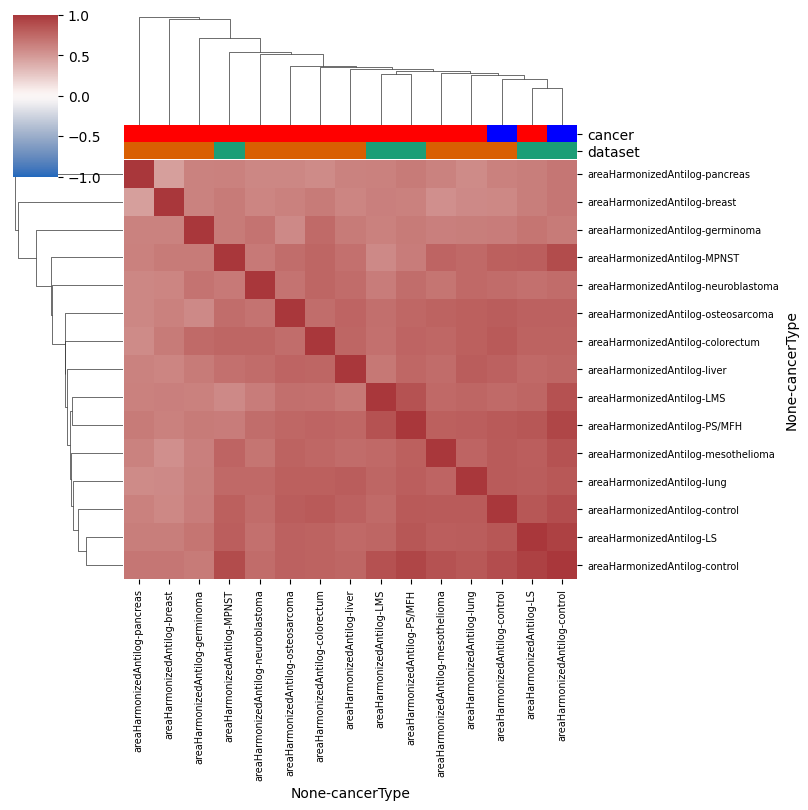

In [32]:
# filter by N samples

dfTemp = dfHarmonized.groupby('cancerType').filter(lambda x: x['sample'].nunique() > 2)

data = pd.pivot_table(
    dfTemp,
    index=['geneNamePrimary'],
    columns = ['cancerType', 'dataset','cancer'],
    values = ['areaHarmonizedAntilog'],
    observed = True
)

# colors
dataT = data.T
dataT.reset_index(level=['cancer','dataset'], inplace = True) # one level for each annotation
cancer = dataT.pop('cancer') # one for each annotation
dataset = dataT.pop('dataset') # one for each annotation
lut = dict(zip(cancer.unique(), "rbg"))
lut.update(dict(zip(dataset.unique(), sns.color_palette("Dark2"))))
lut.update(dict(zip(dataT.index.get_level_values(1).unique(), sns.color_palette("Set2"))))
col_colors = pd.DataFrame({'cancer':cancer.map(lut), 'dataset':dataset.map(lut)})
data = dataT.T # reset back to original pivot table

figure = sns.clustermap(
    data.corr('spearman'), 
    metric = 'euclidean',
    method = 'single',
    #z_score = 0,
    cmap = 'vlag',
    center = 0,
    vmin = -1,
    vmax=1,
    col_colors=col_colors, # annotation colors
    figsize=(9, 9), 
)

figure.ax_heatmap.set_xticklabels(figure.ax_heatmap.get_xmajorticklabels(), fontsize = 7)
figure.ax_heatmap.set_yticklabels(figure.ax_heatmap.get_ymajorticklabels(), fontsize = 7)

### PCA

In [33]:
# count protein IDs, hace to remove 0s NANs first or count doesn't work
# Filter: proteins by N detections and N cancer types across all samples to minimize outliers and since PCA can't have missing data

dfTemp = dfHarmonized

# filter by N detections
dfTemp = dfTemp.query('nSamples > 170') # 50-6 is good. 100 is interesting. 120 is solid. 170 is perhaps final
dfTemp = dfTemp.groupby('cancerType').filter(lambda x: x['sample'].nunique() > 3) # 3-4 is good, 2 is bad

dfPCA = dfTemp

In [36]:
# re-scale dfPCAPivot

scaler = RobustScaler()

data = pd.pivot_table(
    dfPCA,
    index= ['cancerType','dataset'],
    columns = 'geneNamePrimary',
    values = 'areaHarmonized',
    fill_value = 0,
    observed = True
)

# save for later
geneNameColnames = data.columns
cancerTypeRownames = data.index

# fit_transform
dfPivotForPCAScaled = scaler.fit_transform(data)

In [39]:
# use scaled data

from sklearn.decomposition import PCA

scaledData = dfPivotForPCAScaled

components = 6

PCAOut= PCA(n_components=components).fit(scaledData)
varExp = PCAOut.explained_variance_ratio_
cumVarExp = np.cumsum(PCAOut.explained_variance_ratio_) # cumulative variance explained per additional PC

PCAOutFitTransformed = PCA(n_components=components,
    iterated_power = 100, 
    tol = 3,
    whiten = True,
    ).fit(scaledData).transform(scaledData) #These are the Principal Components

### PCA plot + elipsoid

In [40]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [41]:
# prepare the data

dataPCAGrouped = pd.pivot_table(
    dfPCA,
    index= ['cancerType','dataset'],
    columns = 'geneNamePrimary',
    values = 'areaHarmonized',
    fill_value = 0, #'NaN',
    observed = True
)

dataPCAGrouped = dataPCAGrouped.query("cancerType == ['LMS', 'LS', 'MPNST', 'osteosarcoma', 'PS/MFH']")

dfPivotForPCAScaledGrouped = scaler.fit_transform(dataPCAGrouped)

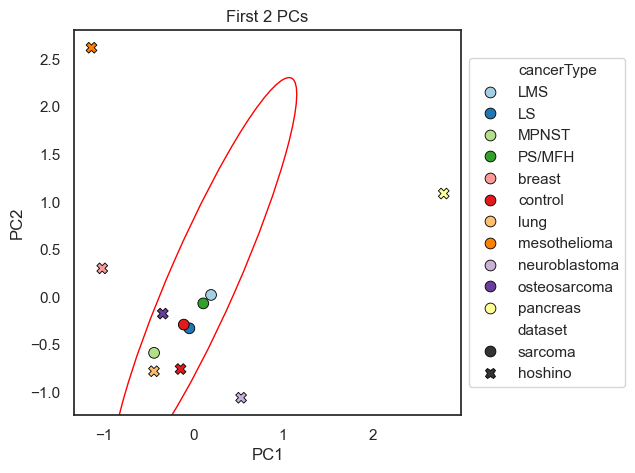

In [42]:
# ellipsoid plot

fig, ax = plt.subplots(1,1, figsize=(5,5))

condition = 'cancerType'
markerStyle = 'dataset' 

color = "Paired" 

sns.set_theme(style="white", palette=None)

sns.scatterplot(x=PCAOutFitTransformed[:, 0],
                y=PCAOutFitTransformed[:, 1],
                hue=cancerTypeRownames.get_level_values(condition),
                palette=color,
                edgecolor='black',
                s=60,
                style=cancerTypeRownames.get_level_values(markerStyle),
               )

x=dfPivotForPCAScaledGrouped[:, 0],
y=dfPivotForPCAScaledGrouped[:, 1],

# The radii of the ellipse
n_std = 2

cov = np.cov(x, y)
pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1]) # Using a special case to obtain the eigenvalues of this two-dimensional dataset.
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
ellipse = Ellipse((0, 0), # ellipse center
    width=ell_radius_x * 2,
    height=ell_radius_y * 2,
    edgecolor='red',
    facecolor = 'none'
)

# Calculate the standard deviation of x from the squareroot of the variance and multiplying with the given number of standard deviations.
scale_x = np.sqrt(cov[0, 0]) * n_std
mean_x = np.mean(x)

# calculate the standard deviation of y
scale_y = np.sqrt(cov[1, 1]) * n_std
mean_y = np.mean(y)

# transform ellipsoid based on means and scale (n_std) above:
transf = transforms.Affine2D().scale(scale_x, scale_y).translate(mean_x, mean_y).rotate_deg(-25)

ellipse.set_transform(transf + ax.transData)
ax.add_patch(ellipse)

plt.title("First 2 PCs")
plt.xlabel('PC1')
plt.ylabel('PC2')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# TSNE using Python

In [49]:
dfTemp = dfHarmonized

# filter
dfTemp = dfTemp.query('nSamples > 170')
dfTemp = dfTemp.groupby('cancerType').filter(lambda x: x['sample'].nunique() > 3)

dfTSNE = dfTemp

In [44]:
# transform protein quantation to for consistency
scaler = RobustScaler()

data = pd.pivot_table(
    dfTSNE,
    index= ['cancerType','dataset'],
    columns = 'geneNamePrimary', 
    values = 'areaHarmonized',
    fill_value = 0,
    observed = True
)

# save for later
geneNameColnames = data.columns
cancerTypeRownames = data.index

dfPivotForTSNEScaled = scaler.fit_transform(data)

In [45]:
X_all = dfPivotForTSNEScaled

y = data.index.get_level_values(0)
y

Index(['LMS', 'LS', 'MPNST', 'PS/MFH', 'breast', 'control', 'control', 'lung',
       'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pancreas'],
      dtype='object', name='cancerType')

In [46]:
# do TSNE
from sklearn.manifold import TSNE

TSNERes = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X_all)

In [47]:
dfTSNE = pd.DataFrame()
dfTSNE["y"] = y
dfTSNE["dataset"] = data.index.get_level_values(1)
dfTSNE["comp-1"] = TSNERes[:,0]
dfTSNE["comp-2"] = TSNERes[:,1]

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_89474/937696507.py:1: UserWarning: The palette list has more values (12) than needed (11), which may not be intended.
  sns.scatterplot(x="comp-1", y="comp-2", hue=dfTSNE.y.tolist(),


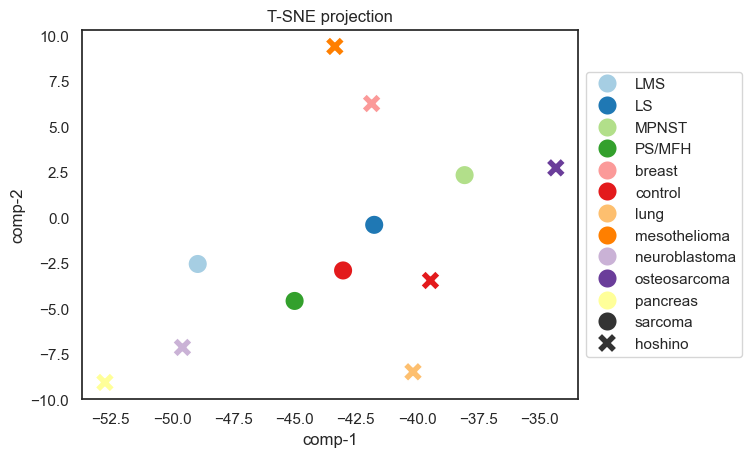

In [48]:
sns.scatterplot(x="comp-1", y="comp-2", hue=dfTSNE.y.tolist(),
                palette=sns.color_palette('Paired'),
                style = 'dataset',
                s = 200,
                data=dfTSNE).set(title="T-SNE projection")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) 